STEP 1.1
IMPORT LIBRARIES

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

STEP 1.2:
IMPORT DATASET

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Define path to your folder (replace with actual path)
    base_folder = '/content/drive/MyDrive/archive/HelmetViolationsV2'
except:
    # If not in Colab, use a relative path
    base_folder = './HelmetViolationsV2'

Mounted at /content/drive


STEP 1.3:
LABEL MAPPING

In [ ]:
# Class mapping for the dataset
CLASS_MAPPING = {
    0: "Number Plate",
    1: "Rider With Helmet",
    2: "Rider Without Helmet",
    3: "Number Plate"
}

STEP 2:
CUSTOM NEURAL NETWORK

In [ ]:
class ImprovedHelmetDetector(nn.Module):
    def __init__(self, num_classes=4, num_preds=2):
        super().__init__()
        self.num_preds = num_preds

        # Shared backbone
        self.shared_backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            self._make_block(64, 64),
            self._make_block(64, 128, stride=2),
        )

        # Separate pathways for classification and regression
        self.cls_backbone = nn.Sequential(
            self._make_block(128, 256, stride=2),
            self._make_block(256, 512, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.reg_backbone = nn.Sequential(
            self._make_block(128, 256, stride=2),
            self._make_block(256, 512, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Classification head for multiple predictions
        self.class_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_preds * num_classes)
        )

        # Regression head for multiple predictions
        self.bbox_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_preds * 4),
            nn.Sigmoid()
        )

        self._initialize_weights()

    def _make_block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.shared_backbone(x)
        cls_features = self.cls_backbone(x)
        reg_features = self.reg_backbone(x)
        class_out = self.class_head(cls_features).view(-1, self.num_preds, 4)
        bbox_out = self.bbox_head(reg_features).view(-1, self.num_preds, 4)
        return class_out, bbox_out

STEP 3:
HELMET DATASET CLASS

In [ ]:
class HelmetDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_size=(224, 224)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".jpeg", ".png"))]
        self.transform = transform
        self.target_w, self.target_h = target_size

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(image_name)[0] + ".txt")

        try:
            image = Image.open(image_path).convert("RGB")
        except:
            image = Image.new("RGB", (self.target_w, self.target_h), color=(0, 0, 0))
            return image, {'boxes': torch.zeros((2, 4)), 'labels': torch.tensor([-1, -1])}

        orig_w, orig_h = image.size

        boxes = []
        labels = []

        try:
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls, x, y, bw, bh = map(float, parts)
                        x1 = (x - bw / 2) * orig_w
                        y1 = (y - bh / 2) * orig_h
                        x2 = (x + bw / 2) * orig_w
                        y2 = (y + bh / 2) * orig_h

                        scale_x = self.target_w / orig_w
                        scale_y = self.target_h / orig_h

                        boxes.append([x1*scale_x, y1*scale_y, x2*scale_x, y2*scale_y])
                        labels.append(int(cls))
        except:
            boxes = [[0, 0, 10, 10]]
            labels = [0]

        # Reorder: Prioritize helmet-related classes (0-2), number plate (3) second
        reordered = list(zip(labels, boxes))
        reordered.sort(key=lambda x: (x[0] == 3))  # Number plate last unless only object
        labels = [x[0] for x in reordered]
        boxes = [x[1] for x in reordered]

        # Pad to 2 objects
        while len(boxes) < 2:
            boxes.append([0, 0, 0, 0])
            labels.append(-1)

        boxes = torch.tensor(boxes[:2], dtype=torch.float32)
        labels = torch.tensor(labels[:2], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, {'boxes': boxes, 'labels': labels}

STEP 4:
MODEL PRE PROCCESSING

In [ ]:
"""STEP 4: MODEL PREPROCESSING"""

torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_image_dir = os.path.join(base_folder, "train/images")
train_label_dir = os.path.join(base_folder, "train/labels")
val_image_dir = os.path.join(base_folder, "valid/images")
val_label_dir = os.path.join(base_folder, "valid/labels")
test_image_dir = os.path.join(base_folder, "test/images")
test_label_dir = os.path.join(base_folder, "test/labels")
print(base_folder)

train_dataset = HelmetDataset(train_image_dir, train_label_dir, transform=train_transform)
val_dataset = HelmetDataset(val_image_dir, val_label_dir, transform=val_transform)
test_dataset = HelmetDataset(test_image_dir, test_label_dir, transform=val_transform)

# Added drop_last=True to ensure consistent batch sizes
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2, drop_last=True)

model = ImprovedHelmetDetector(num_classes=4, num_preds=2).to(device)

Using device: cpu
/content/drive/MyDrive/archive/HelmetViolationsV2


STEP 5.1:
TRAINING MODEL

In [ ]:
def train_model(model, train_loader, val_loader, epochs=20, device='cpu'):
    class_weights = torch.tensor([1.0, 2.0, 2.0, 2.0], device=device)
    loss_cls = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-1)
    loss_box = nn.MSELoss()

    optimizer = torch.optim.AdamW([
        {'params': model.shared_backbone.parameters(), 'lr': 3e-5},
        {'params': list(model.cls_backbone.parameters()) + list(model.class_head.parameters()), 'lr': 3e-4},
        {'params': list(model.reg_backbone.parameters()) + list(model.bbox_head.parameters()), 'lr': 1e-4}
    ], weight_decay=1e-4)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model = None

    for epoch in range(epochs):
        model.train()
        total_loss, total_cls, total_box = 0, 0, 0

        for batch_idx, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            labels = targets['labels'].to(device)  # [B, 2]
            boxes = targets['boxes'].to(device) / 224.0  # [B, 2, 4]

            pred_cls, pred_box = model(images)  # [B, 2, 4], [B, 2, 4]

            cls_loss_batch = 0.0
            box_loss_batch = 0.0

            for i in range(2):
                mask = labels[:, i] != -1
                if mask.sum() > 0:
                    cls_loss_batch += loss_cls(pred_cls[mask, i], labels[mask, i])
                    box_loss_batch += loss_box(pred_box[mask, i], boxes[mask, i])

            if epoch < 5:
                loss = 5.0 * cls_loss_batch + 0.5 * box_loss_batch
            else:
                loss = 2.0 * cls_loss_batch + box_loss_batch

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()
            total_cls += cls_loss_batch.item()
            total_box += box_loss_batch.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} | "
                      f"Loss: {loss.item():.4f} | Cls: {cls_loss_batch:.4f} | Box: {box_loss_batch:.4f}")

        model.eval()
        val_loss, val_cls, val_box = 0, 0, 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                labels = targets['labels'].to(device)
                boxes = targets['boxes'].to(device) / 224.0

                pred_cls, pred_box = model(images)
                cls_loss_batch = 0.0
                box_loss_batch = 0.0

                for i in range(2):
                    mask = labels[:, i] != -1
                    if mask.sum() > 0:
                        cls_loss_batch += loss_cls(pred_cls[mask, i], labels[mask, i])
                        box_loss_batch += loss_box(pred_box[mask, i], boxes[mask, i])

                if epoch < 5:
                    loss = 5.0 * cls_loss_batch + 0.5 * box_loss_batch
                else:
                    loss = 2.0 * cls_loss_batch + box_loss_batch

                val_loss += loss.item()
                val_cls += cls_loss_batch.item()
                val_box += box_loss_batch.item()

        avg_train_loss = total_loss / len(train_loader)
        avg_train_cls = total_cls / len(train_loader)
        avg_train_box = total_box / len(train_loader)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_cls = val_cls / len(val_loader)
        avg_val_box = val_box / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict().copy()
            print(f"New best model saved! (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{epochs} Summary:")
        print(f"  Training   | Loss: {avg_train_loss:.4f} | Cls Loss: {avg_train_cls:.4f} | Box Loss: {avg_train_box:.4f}")
        print(f"  Validation | Loss: {avg_val_loss:.4f} | Cls Loss: {avg_val_cls:.4f} | Box Loss: {avg_val_box:.4f}")
        print("-" * 80)

    if best_model is not None:
        model.load_state_dict(best_model)

    return model, train_losses, val_losses

trained_model, train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=2,
    device=device
)

Epoch 1/2 | Batch 10/120 | Loss: 12.7250 | Cls: 2.5295 | Box: 0.1550
Epoch 1/2 | Batch 20/120 | Loss: 10.5129 | Cls: 2.0933 | Box: 0.0924
Epoch 1/2 | Batch 30/120 | Loss: 7.4781 | Cls: 1.4873 | Box: 0.0834
Epoch 1/2 | Batch 40/120 | Loss: 7.0269 | Cls: 1.3964 | Box: 0.0901
Epoch 1/2 | Batch 50/120 | Loss: 6.5970 | Cls: 1.3107 | Box: 0.0869
Epoch 1/2 | Batch 60/120 | Loss: 7.9957 | Cls: 1.5916 | Box: 0.0753
Epoch 1/2 | Batch 70/120 | Loss: 7.8777 | Cls: 1.5702 | Box: 0.0535
Epoch 1/2 | Batch 80/120 | Loss: 4.9884 | Cls: 0.9925 | Box: 0.0514
Epoch 1/2 | Batch 90/120 | Loss: 5.9230 | Cls: 1.1780 | Box: 0.0662
Epoch 1/2 | Batch 100/120 | Loss: 6.0084 | Cls: 1.1963 | Box: 0.0534
Epoch 1/2 | Batch 110/120 | Loss: 4.9987 | Cls: 0.9944 | Box: 0.0538
Epoch 1/2 | Batch 120/120 | Loss: 6.2696 | Cls: 1.2470 | Box: 0.0691
New best model saved! (Val Loss: 3.4827)
Epoch 1/2 Summary:
  Training   | Loss: 7.8239 | Cls Loss: 1.5574 | Box Loss: 0.0740
  Validation | Loss: 3.4827 | Cls Loss: 0.6936 | Box 

STEP 5.2:
SAVING MODEL

In [ ]:
torch.save(trained_model.state_dict(), 'helmet_detection_model_custom.pth')
print("Model saved successfully!")

Model saved successfully!


STEP 5.3:
LOSS CURVES PLOTTING

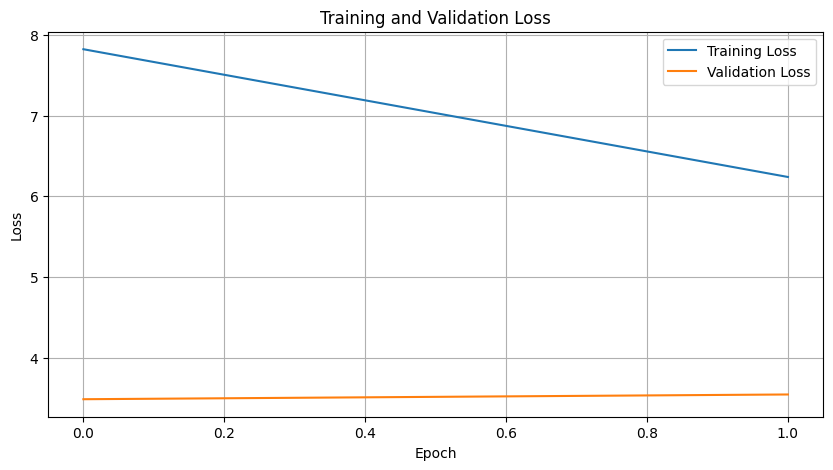

In [ ]:
    # Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

STEP 6:
MODEL EVALUATION

Unique true labels (filtered): [0 1 2]
Unique predicted labels (filtered): [0 1 2]

=== EVALUATION METRICS ===
Classification Accuracy: 0.8519
Average IoU: 0.2632

Classification Report:
                      precision    recall  f1-score   support

        Number Plate       0.95      0.88      0.91        24
   Rider With Helmet       0.50      1.00      0.67         1
Rider Without Helmet       0.33      0.50      0.40         2

            accuracy                           0.85        27
           macro avg       0.60      0.79      0.66        27
        weighted avg       0.89      0.85      0.87        27



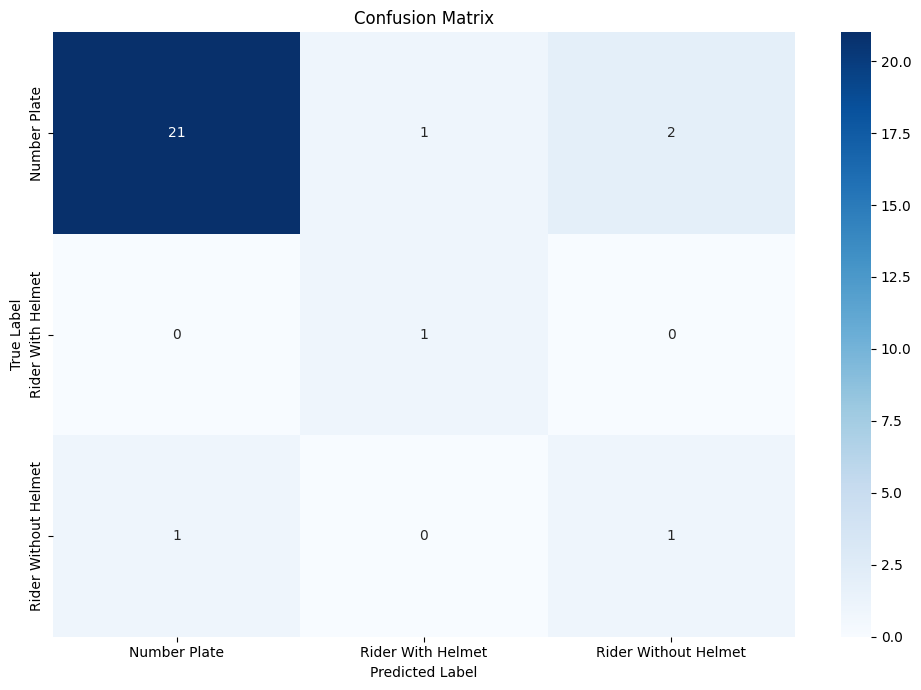

In [ ]:
"""STEP 6: MODEL EVALUATION"""

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    if inter_area == 0:
        return 0.0

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area

def evaluate_model(model, val_loader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    all_ious = []

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            labels = targets['labels'].to(device)
            boxes = targets['boxes'].to(device)

            pred_cls, pred_box = model(images)
            pred_labels = torch.argmax(pred_cls, dim=2)
            pred_box = pred_box * 224.0

            for i in range(images.size(0)):
                for j in range(2):
                    label = labels[i, j].item()
                    pred_label = pred_labels[i, j].item()
                    if label != -1:
                        all_preds.append(pred_label)
                        all_labels.append(label)
                        if pred_label != 0:
                            iou = compute_iou(pred_box[i, j].cpu().numpy(), boxes[i, j].cpu().numpy())
                        else:
                            iou = np.nan  # Skip IoU for pred_label == 0 by marking as NaN
                        all_ious.append(iou)

    # Convert to numpy arrays for easier filtering
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_ious = np.array(all_ious)

    # Filter out label 3 from evaluation
    mask = all_labels != 3
    filtered_preds = all_preds[mask]
    filtered_labels = all_labels[mask]
    filtered_ious = all_ious[mask]

    accuracy = accuracy_score(filtered_labels, filtered_preds)
    avg_iou = np.nanmean(filtered_ious)  # ignore NaNs for averaging

    print(f"Unique true labels (filtered): {np.unique(filtered_labels)}")
    print(f"Unique predicted labels (filtered): {np.unique(filtered_preds)}")

    print("\n=== EVALUATION METRICS ===")
    print(f"Classification Accuracy: {accuracy:.4f}")
    print(f"Average IoU: {avg_iou:.4f}")
    print("\nClassification Report:")
    # Only include labels 0,1,2
    print(classification_report(
        filtered_labels,
        filtered_preds,
        labels=[0, 1, 2],
        target_names=[CLASS_MAPPING[i] for i in [0, 1, 2]],
        zero_division=0
    ))

    # Confusion matrix without label 3
    cm = confusion_matrix(filtered_labels, filtered_preds, labels=[0, 1, 2])
    cm_df = pd.DataFrame(cm, index=[CLASS_MAPPING[i] for i in [0, 1, 2]],
                         columns=[CLASS_MAPPING[i] for i in [0, 1, 2]])
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'avg_iou': avg_iou,
        'predictions': filtered_preds.tolist(),
        'true_labels': filtered_labels.tolist(),
        'ious': filtered_ious.tolist()
    }



eval_results = evaluate_model(trained_model, val_loader, device=device)

STEP JUMP:
LOADING SAVED MODEL INSTEAD OF TRAINING FROM SCRATCH

In [ ]:
trained_model = ImprovedHelmetDetector(num_classes=4)
trained_model.load_state_dict(torch.load('helmet_detection_model_custom (1).pth'))
trained_model.eval()

ImprovedHelmetDetector(
  (shared_backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (5): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 1

STEP 8.2:
OUTPUT ON /VALID

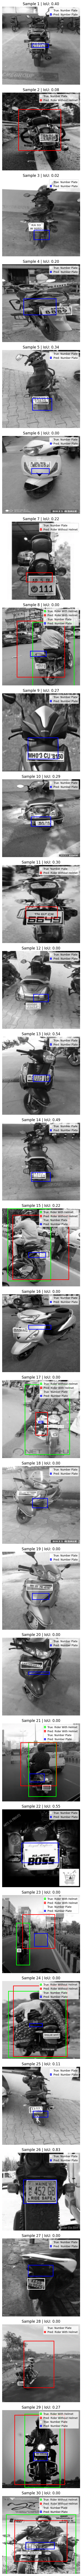

In [ ]:
def denormalize_image(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

import matplotlib.patches as patches

def visualize_predictions(model, val_loader, device='cpu', num_samples=5):
    model.eval()
    plt.figure(figsize=(20, 4 * num_samples))

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    with torch.no_grad():
        count = 0
        for images, targets in val_loader:
            if count >= num_samples:
                break

            images = images.to(device)
            pred_cls, pred_box = model(images)
            pred_labels = torch.argmax(pred_cls, dim=2)[0]
            pred_box = (pred_box * 224.0)[0].cpu().numpy()

            image = denormalize_image(images[0].cpu(), mean, std)
            image = image.permute(1, 2, 0).numpy()
            image = np.clip(image, 0, 1)

            true_boxes = targets['boxes'][0].cpu().numpy()
            true_labels = targets['labels'][0].cpu().numpy()

            plt.subplot(num_samples, 1, count + 1)
            plt.imshow(image)

            iou = None  # Initialize IoU variable for this sample

            for i in range(2):
                if true_labels[i] == -1:
                    continue

                true_box = true_boxes[i]
                true_label = CLASS_MAPPING[true_labels[i]]
                pred_label = CLASS_MAPPING[pred_labels[i].item()]
                pred_box_i = pred_box[i]

                # Compute IoU only if true label is 1 or 2, skip if 0
                if true_labels[i] in [1, 2]:
                    iou1 = compute_iou(pred_box_i, true_box)
                else:
                    iou2 = compute_iou(pred_box_i, true_box)

                # Draw true box (green for labels 1 & 2, white for label 0)
                rect_true = patches.Rectangle(
                    (true_box[0], true_box[1]),
                    true_box[2] - true_box[0],
                    true_box[3] - true_box[1],
                    linewidth=2,
                    edgecolor='white' if true_labels[i] == 0 else 'lime',
                    facecolor='none',
                    label=f'True: {true_label}'
                )
                plt.gca().add_patch(rect_true)

                # Draw predicted box (red for helmet-related, blue for number plate)
                edgecolor = 'blue' if pred_labels[i].item() == 0 else 'red'
                rect_pred = patches.Rectangle(
                    (pred_box_i[0], pred_box_i[1]),
                    pred_box_i[2] - pred_box_i[0],
                    pred_box_i[3] - pred_box_i[1],
                    linewidth=2,
                    edgecolor=edgecolor,
                    facecolor='none',
                    label=f'Pred: {pred_label}'
                )
                plt.gca().add_patch(rect_pred)

            # Display IoU if computed, else show 'N/A'
            if iou is not None:
                plt.title(f"Sample {count+1} | IoU: {iou1:.2f}")
            else:
                plt.title(f"Sample {count+1} | IoU: {iou2:.2f}")

            plt.legend(handlelength=0.5, handleheight=0.5, fontsize='small')
            plt.axis('off')

            count += 1

    plt.tight_layout()
    plt.show()


visualize_predictions(trained_model,
                     DataLoader(val_dataset, batch_size=1, shuffle=True),
                     device=device,
                     num_samples=30)

STEP 9: TESTING
OUTPUT ON /TEST

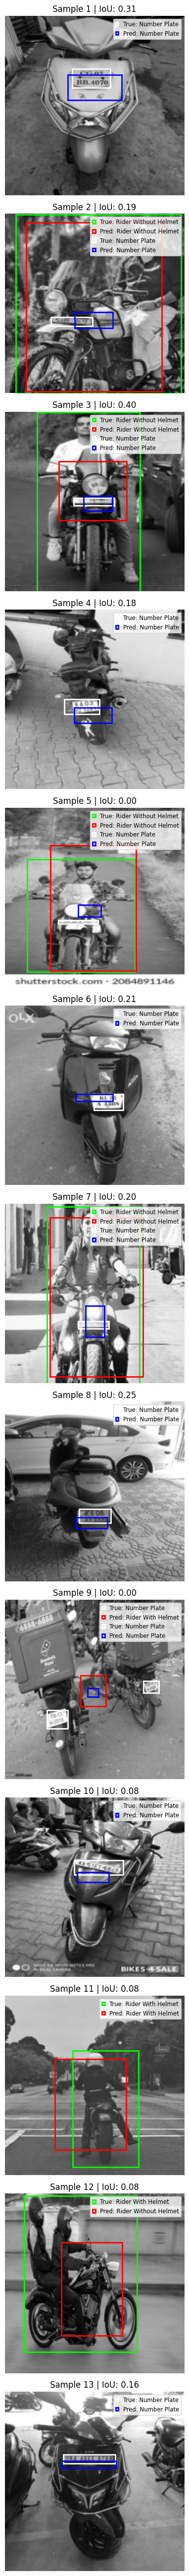

In [ ]:
visualize_predictions(trained_model,
DataLoader(test_dataset, batch_size=1, shuffle=True),
device=device,
num_samples=30)

STEP 9.1: OUPUT ON UNSEEN IMAGE DATA FROM GOOGLE

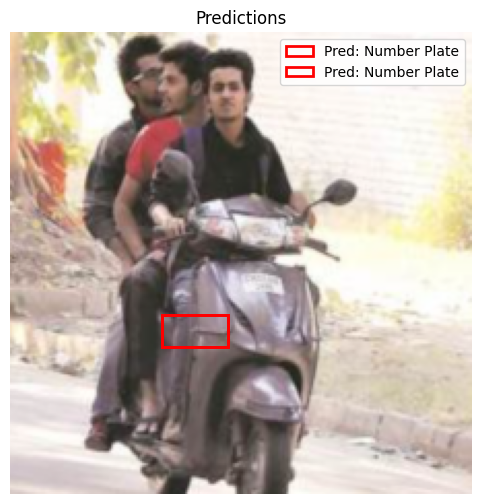

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch
import numpy as np

# Load and transform image (same as val_transform)
def load_and_prepare_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)  # Add batch dimension

# Denormalize for visualization
def denormalize_image(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Inference and visualization
def predict_and_visualize_single_image(image_path, model, device):
    model.eval()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    image_tensor = load_and_prepare_image(image_path).to(device)

    with torch.no_grad():
        pred_cls, pred_box = model(image_tensor)
        pred_label = torch.argmax(pred_cls, dim=1).item()
        pred_box = (pred_box * 224.0)[0].cpu().numpy()

    # Prepare image for display
    image = denormalize_image(image_tensor[0].cpu(), mean, std)
    image = image.permute(1, 2, 0).numpy()
    image = np.clip(image, 0, 1)

    # Plot with predicted box
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

    rect_pred = patches.Rectangle(
        (pred_box[0], pred_box[1]),
        pred_box[2] - pred_box[0],
        pred_box[3] - pred_box[1],
        linewidth=2, edgecolor='red', facecolor='none',
        label=f'Pred: {CLASS_MAPPING[pred_label]}'
    )
    plt.gca().add_patch(rect_pred)
    plt.title(f"Predicted: {CLASS_MAPPING[pred_label]}")
    plt.axis('off')
    plt.legend()
    plt.show()

predict_and_visualize_single_image("/content/image1.jpg", trained_model, device)


STEP 9.2: OUTPUT ON VIDEO INPUT UNSEEN

In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Setup transforms (same as your val_transform)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Denormalization for visualization
def denormalize_image(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Inference on a single frame
def predict_on_frame(frame, model, device):
    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).convert("RGB")
    input_tensor = val_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_cls, pred_box = model(input_tensor)
        pred_label = torch.argmax(pred_cls, dim=1).item()
        pred_box = (pred_box * 224.0)[0].cpu().numpy()

    # Denormalize for drawing (but not needed for frame output unless visualizing)
    return pred_box, pred_label

# Annotate a frame with predicted box and label
def annotate_frame(frame, box, label, class_mapping):
    h, w, _ = frame.shape
    scale_x = w / 224.0
    scale_y = h / 224.0

    x1, y1, x2, y2 = box
    x1 = int(x1 * scale_x)
    y1 = int(y1 * scale_y)
    x2 = int(x2 * scale_x)
    y2 = int(y2 * scale_y)

    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(frame, class_mapping[label], (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    return frame

# Process video
def process_video(input_path, output_path, model, class_mapping, device='cpu'):
    cap = cv2.VideoCapture(input_path)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    model.eval()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        box, label = predict_on_frame(frame, model, device)
        annotated_frame = annotate_frame(frame, box, label, class_mapping)
        out.write(annotated_frame)

    cap.release()
    out.release()
    print(f"✅ Output video saved to: {output_path}")



process_video(
    input_path="/content/222.mp4",
    output_path="/content/output_annotated3.mp4",
    model=trained_model,
    class_mapping=CLASS_MAPPING,
    device=device
)
